# Training ANN model on data

    Find best size for test set

In [11]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

import keras
from keras.models import Sequential # to initialise the NN
from keras.layers import Dense # to create layers
from keras.layers import Dropout
from keras import initializers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

In [12]:
test_set_range = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]


for i in test_set_range:
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # 2018 data
    data = data.loc[data.index > 2018100000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(method = 'ffill', inplace = True)
    y.fillna(method = 'ffill', inplace = True)

    X = X.round(20)
    
    # divide data into train and test with 10% test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    def regressor_tunning(n_hidden = 5, 
                          n_neurons = 40, 
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        optimizer = optimizers.Adamax(lr = 0.001)
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model

    tscv = TimeSeriesSplit(n_splits = 10)
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 100)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)


C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
26/26 [==============================] - 0s 3ms/step - loss: 14372.6318 - mse: 14372.6318 - mae: 114.2134
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 13796.5244 - mse: 13796.5244 - mae: 111.6271
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 11607.3350 - mse: 11607.3350 - mae: 101.2698
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 5407.7188 - mse: 5407.7188 - mae: 61.9327
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 1863.8568 - mse: 1863.8568 - mae: 30.4248
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 1746.9758 - mse: 1746.9756 - mae: 29.4891
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 1762.5775 - mse: 1762.5775 - mae: 28.5549
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 1760.8071 - mse: 1760.8071 - mae: 28.6324
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss

52/52 [==============================] - 0s 2ms/step - loss: 1546.8121 - mse: 1546.8121 - mae: 27.4353
Epoch 41/100
52/52 [==============================] - 0s 3ms/step - loss: 1586.7640 - mse: 1586.7640 - mae: 27.8697
Epoch 42/100
52/52 [==============================] - 0s 4ms/step - loss: 1534.3878 - mse: 1534.3878 - mae: 26.7145
Epoch 43/100
52/52 [==============================] - 0s 3ms/step - loss: 1543.1968 - mse: 1543.1968 - mae: 26.5874
Epoch 44/100
52/52 [==============================] - 0s 2ms/step - loss: 1543.9800 - mse: 1543.9800 - mae: 27.3205
Epoch 45/100
52/52 [==============================] - 0s 2ms/step - loss: 1529.8003 - mse: 1529.8003 - mae: 26.9871
Epoch 46/100
52/52 [==============================] - 0s 2ms/step - loss: 1549.4271 - mse: 1549.4271 - mae: 27.5995
Epoch 47/100
52/52 [==============================] - 0s 2ms/step - loss: 1549.7167 - mse: 1549.7167 - mae: 27.3051
Epoch 48/100
52/52 [==============================] - 0s 3ms/step - loss: 1619.4623 -

77/77 [==============================] - 0s 2ms/step - loss: 1202.9380 - mse: 1202.9380 - mae: 24.5486
Epoch 81/100
77/77 [==============================] - 0s 2ms/step - loss: 1297.5275 - mse: 1297.5275 - mae: 25.1755
Epoch 82/100
77/77 [==============================] - 0s 2ms/step - loss: 1284.4868 - mse: 1284.4868 - mae: 24.9909
Epoch 83/100
77/77 [==============================] - 0s 2ms/step - loss: 1303.6565 - mse: 1303.6565 - mae: 24.7994
Epoch 84/100
77/77 [==============================] - 0s 3ms/step - loss: 1294.2285 - mse: 1294.2285 - mae: 25.2406
Epoch 85/100
77/77 [==============================] - 0s 2ms/step - loss: 1274.2517 - mse: 1274.2517 - mae: 24.7643
Epoch 86/100
77/77 [==============================] - 0s 2ms/step - loss: 1258.6045 - mse: 1258.6045 - mae: 24.6984
Epoch 87/100
77/77 [==============================] - 0s 3ms/step - loss: 1220.3795 - mse: 1220.3795 - mae: 24.5563
Epoch 88/100
77/77 [==============================] - 0s 3ms/step - loss: 1242.8435 -

Epoch 16/100
128/128 [==============================] - 0s 3ms/step - loss: 2259.7764 - mse: 2259.7764 - mae: 25.2880
Epoch 17/100
128/128 [==============================] - 0s 3ms/step - loss: 2288.3264 - mse: 2288.3264 - mae: 25.3833
Epoch 18/100
128/128 [==============================] - 0s 3ms/step - loss: 2254.6812 - mse: 2254.6812 - mae: 25.4998
Epoch 19/100
128/128 [==============================] - 0s 2ms/step - loss: 2235.8645 - mse: 2235.8645 - mae: 25.1146
Epoch 20/100
128/128 [==============================] - 0s 3ms/step - loss: 2277.6626 - mse: 2277.6626 - mae: 25.7168
Epoch 21/100
128/128 [==============================] - 0s 2ms/step - loss: 2249.4150 - mse: 2249.4150 - mae: 25.0894
Epoch 22/100
128/128 [==============================] - 0s 2ms/step - loss: 2273.1731 - mse: 2273.1731 - mae: 25.4196
Epoch 23/100
128/128 [==============================] - 0s 3ms/step - loss: 2254.0771 - mse: 2254.0771 - mae: 25.4100
Epoch 24/100
128/128 [==============================] - 

153/153 [==============================] - 0s 3ms/step - loss: 2087.6772 - mse: 2087.6772 - mae: 24.7554
Epoch 54/100
153/153 [==============================] - 0s 3ms/step - loss: 2049.8848 - mse: 2049.8848 - mae: 24.5144
Epoch 55/100
153/153 [==============================] - 0s 3ms/step - loss: 2092.1130 - mse: 2092.1128 - mae: 24.8839
Epoch 56/100
153/153 [==============================] - 0s 3ms/step - loss: 2066.3838 - mse: 2066.3838 - mae: 24.7361
Epoch 57/100
153/153 [==============================] - 0s 3ms/step - loss: 2061.3945 - mse: 2061.3945 - mae: 24.6477
Epoch 58/100
153/153 [==============================] - 0s 3ms/step - loss: 2090.4326 - mse: 2090.4326 - mae: 24.9409
Epoch 59/100
153/153 [==============================] - 0s 2ms/step - loss: 2062.6909 - mse: 2062.6909 - mae: 24.7413
Epoch 60/100
153/153 [==============================] - 0s 2ms/step - loss: 2055.2180 - mse: 2055.2180 - mae: 24.7302
Epoch 61/100
153/153 [==============================] - 0s 2ms/step -

179/179 [==============================] - 1s 3ms/step - loss: 2156.3196 - mse: 2156.3196 - mae: 25.2422
Epoch 91/100
179/179 [==============================] - 1s 3ms/step - loss: 2124.9114 - mse: 2124.9114 - mae: 25.5600
Epoch 92/100
179/179 [==============================] - 1s 3ms/step - loss: 2106.5391 - mse: 2106.5391 - mae: 25.2795
Epoch 93/100
179/179 [==============================] - 0s 3ms/step - loss: 2141.3469 - mse: 2141.3469 - mae: 25.6792
Epoch 94/100
179/179 [==============================] - 0s 2ms/step - loss: 2123.1885 - mse: 2123.1885 - mae: 25.0920
Epoch 95/100
179/179 [==============================] - 1s 3ms/step - loss: 2120.6675 - mse: 2120.6675 - mae: 25.4224
Epoch 96/100
179/179 [==============================] - 0s 3ms/step - loss: 2109.4517 - mse: 2109.4517 - mae: 25.5102
Epoch 97/100
179/179 [==============================] - 1s 3ms/step - loss: 2121.7512 - mse: 2121.7512 - mae: 25.1916
Epoch 98/100
179/179 [==============================] - 0s 3ms/step -

229/229 [==============================] - 1s 3ms/step - loss: 1778.8131 - mse: 1778.8131 - mae: 23.5756
Epoch 29/100
229/229 [==============================] - 1s 3ms/step - loss: 1776.8245 - mse: 1776.8245 - mae: 23.6020
Epoch 30/100
229/229 [==============================] - 1s 3ms/step - loss: 1788.7760 - mse: 1788.7760 - mae: 23.7420
Epoch 31/100
229/229 [==============================] - 0s 2ms/step - loss: 1789.2777 - mse: 1789.2777 - mae: 23.6432
Epoch 32/100
229/229 [==============================] - 0s 2ms/step - loss: 1820.8455 - mse: 1820.8455 - mae: 23.7025
Epoch 33/100
229/229 [==============================] - 0s 2ms/step - loss: 1752.6080 - mse: 1752.6080 - mae: 23.5822
Epoch 34/100
229/229 [==============================] - 1s 2ms/step - loss: 1753.3600 - mse: 1753.3600 - mae: 23.4000
Epoch 35/100
229/229 [==============================] - 1s 3ms/step - loss: 1769.6022 - mse: 1769.6022 - mae: 23.5987
Epoch 36/100
229/229 [==============================] - 1s 2ms/step -

255/255 [==============================] - 1s 3ms/step - loss: 1664.7859 - mse: 1664.7859 - mae: 22.9453
Epoch 66/100
255/255 [==============================] - 1s 3ms/step - loss: 1657.1583 - mse: 1657.1583 - mae: 22.9592
Epoch 67/100
255/255 [==============================] - 1s 3ms/step - loss: 1669.1892 - mse: 1669.1892 - mae: 23.0116
Epoch 68/100
255/255 [==============================] - 1s 3ms/step - loss: 1633.5543 - mse: 1633.5543 - mae: 23.0211
Epoch 69/100
255/255 [==============================] - 1s 3ms/step - loss: 1714.9014 - mse: 1714.9014 - mae: 23.0717
Epoch 70/100
255/255 [==============================] - 1s 3ms/step - loss: 1659.0608 - mse: 1659.0608 - mae: 22.8976
Epoch 71/100
255/255 [==============================] - 1s 3ms/step - loss: 1672.9758 - mse: 1672.9758 - mae: 22.8386
Epoch 72/100
255/255 [==============================] - 1s 3ms/step - loss: 1668.3488 - mse: 1668.3488 - mae: 23.1709
Epoch 73/100
255/255 [==============================] - 1s 3ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
26/26 [==============================] - 0s 3ms/step - loss: 14371.0400 - mse: 14371.0400 - mae: 114.1537
Epoch 2/100
26/26 [==============================] - 0s 3ms/step - loss: 13868.7783 - mse: 13868.7783 - mae: 111.9250
Epoch 3/100
26/26 [==============================] - 0s 3ms/step - loss: 11988.4775 - mse: 11988.4775 - mae: 103.3009
Epoch 4/100
26/26 [==============================] - 0s 3ms/step - loss: 7503.9351 - mse: 7503.9351 - mae: 76.7527
Epoch 5/100
26/26 [==============================] - 0s 3ms/step - loss: 2192.0076 - mse: 2192.0076 - mae: 33.4430
Epoch 6/100
26/26 [==============================] - 0s 3ms/step - loss: 1823.2122 - mse: 1823.2122 - mae: 29.8122
Epoch 7/100
26/26 [==============================] - 0s 3ms/step - loss: 1837.8535 - mse: 1837.8535 - mae: 29.6973
Epoch 8/100
26/26 [==============================] - 0s 3ms/step - loss: 1845.2252 - mse: 1845.2252 - mae: 28.5521
Epoch 9/100
26/26 [==============================] - 0s 3ms/step - loss

50/50 [==============================] - 0s 2ms/step - loss: 1466.9613 - mse: 1466.9613 - mae: 26.4863
Epoch 41/100
50/50 [==============================] - 0s 2ms/step - loss: 1572.2500 - mse: 1572.2500 - mae: 27.0491
Epoch 42/100
50/50 [==============================] - 0s 3ms/step - loss: 1583.0889 - mse: 1583.0889 - mae: 28.4946
Epoch 43/100
50/50 [==============================] - 0s 3ms/step - loss: 1595.9855 - mse: 1595.9855 - mae: 27.0215
Epoch 44/100
50/50 [==============================] - 0s 3ms/step - loss: 1579.9116 - mse: 1579.9116 - mae: 27.5977
Epoch 45/100
50/50 [==============================] - 0s 3ms/step - loss: 1616.6534 - mse: 1616.6534 - mae: 27.5157
Epoch 46/100
50/50 [==============================] - 0s 3ms/step - loss: 1581.5706 - mse: 1581.5706 - mae: 27.5791
Epoch 47/100
50/50 [==============================] - 0s 3ms/step - loss: 1551.7657 - mse: 1551.7657 - mae: 26.7111
Epoch 48/100
50/50 [==============================] - 0s 3ms/step - loss: 1597.7612 -

75/75 [==============================] - 0s 3ms/step - loss: 1266.3934 - mse: 1266.3934 - mae: 24.6224
Epoch 81/100
75/75 [==============================] - 0s 3ms/step - loss: 1288.4795 - mse: 1288.4795 - mae: 24.8711
Epoch 82/100
75/75 [==============================] - 0s 3ms/step - loss: 1234.9062 - mse: 1234.9062 - mae: 24.1333
Epoch 83/100
75/75 [==============================] - 0s 2ms/step - loss: 1268.2716 - mse: 1268.2716 - mae: 25.2644
Epoch 84/100
75/75 [==============================] - 0s 2ms/step - loss: 1305.4274 - mse: 1305.4274 - mae: 25.1648
Epoch 85/100
75/75 [==============================] - 0s 3ms/step - loss: 1298.2025 - mse: 1298.2024 - mae: 24.9328
Epoch 86/100
75/75 [==============================] - 0s 3ms/step - loss: 1308.1733 - mse: 1308.1733 - mae: 25.2146
Epoch 87/100
75/75 [==============================] - 0s 3ms/step - loss: 1263.5281 - mse: 1263.5281 - mae: 24.7836
Epoch 88/100
75/75 [==============================] - 0s 3ms/step - loss: 1274.7816 -

124/124 [==============================] - 0s 2ms/step - loss: 2287.8105 - mse: 2287.8105 - mae: 25.5000
Epoch 19/100
124/124 [==============================] - 0s 2ms/step - loss: 2333.3271 - mse: 2333.3271 - mae: 26.0930
Epoch 20/100
124/124 [==============================] - 0s 2ms/step - loss: 2313.7021 - mse: 2313.7021 - mae: 26.0344
Epoch 21/100
124/124 [==============================] - 0s 2ms/step - loss: 2278.4514 - mse: 2278.4514 - mae: 25.3538
Epoch 22/100
124/124 [==============================] - 0s 2ms/step - loss: 2261.7092 - mse: 2261.7092 - mae: 25.1165
Epoch 23/100
124/124 [==============================] - 0s 2ms/step - loss: 2274.1711 - mse: 2274.1711 - mae: 25.3459
Epoch 24/100
124/124 [==============================] - 0s 2ms/step - loss: 2289.7996 - mse: 2289.7996 - mae: 25.5948
Epoch 25/100
124/124 [==============================] - 0s 2ms/step - loss: 2300.9604 - mse: 2300.9604 - mae: 26.0607
Epoch 26/100
124/124 [==============================] - 0s 2ms/step -

149/149 [==============================] - 0s 2ms/step - loss: 2115.8660 - mse: 2115.8660 - mae: 25.2783
Epoch 56/100
149/149 [==============================] - 0s 2ms/step - loss: 2078.7446 - mse: 2078.7446 - mae: 24.7282
Epoch 57/100
149/149 [==============================] - 0s 3ms/step - loss: 2129.6973 - mse: 2129.6973 - mae: 25.0569
Epoch 58/100
149/149 [==============================] - 0s 3ms/step - loss: 2096.2236 - mse: 2096.2236 - mae: 24.9210
Epoch 59/100
149/149 [==============================] - 0s 3ms/step - loss: 2119.4976 - mse: 2119.4976 - mae: 24.7931
Epoch 60/100
149/149 [==============================] - 0s 3ms/step - loss: 2103.2834 - mse: 2103.2834 - mae: 24.8301
Epoch 61/100
149/149 [==============================] - 0s 3ms/step - loss: 2130.6638 - mse: 2130.6638 - mae: 25.0144
Epoch 62/100
149/149 [==============================] - 0s 3ms/step - loss: 2120.8364 - mse: 2120.8364 - mae: 25.1008
Epoch 63/100
149/149 [==============================] - 0s 3ms/step -

174/174 [==============================] - 0s 3ms/step - loss: 2190.6553 - mse: 2190.6553 - mae: 25.6895
Epoch 94/100
174/174 [==============================] - 0s 2ms/step - loss: 2213.8118 - mse: 2213.8118 - mae: 25.8791
Epoch 95/100
174/174 [==============================] - 1s 3ms/step - loss: 2224.7302 - mse: 2224.7302 - mae: 25.6947
Epoch 96/100
174/174 [==============================] - 0s 3ms/step - loss: 2185.5679 - mse: 2185.5679 - mae: 25.8768
Epoch 97/100
174/174 [==============================] - 0s 3ms/step - loss: 2208.2734 - mse: 2208.2734 - mae: 25.7535
Epoch 98/100
174/174 [==============================] - 0s 3ms/step - loss: 2187.0901 - mse: 2187.0901 - mae: 25.5696
Epoch 99/100
174/174 [==============================] - 0s 2ms/step - loss: 2153.9172 - mse: 2153.9172 - mae: 25.6569
Epoch 100/100
174/174 [==============================] - 0s 2ms/step - loss: 2186.0996 - mse: 2186.0996 - mae: 25.4180
7
Epoch 1/100
199/199 [==============================] - 0s 2ms/step

223/223 [==============================] - 1s 3ms/step - loss: 1879.2515 - mse: 1879.2515 - mae: 23.9202
Epoch 32/100
223/223 [==============================] - 1s 3ms/step - loss: 1761.9355 - mse: 1761.9355 - mae: 23.4909
Epoch 33/100
223/223 [==============================] - 1s 3ms/step - loss: 1781.7262 - mse: 1781.7262 - mae: 23.9299
Epoch 34/100
223/223 [==============================] - 1s 3ms/step - loss: 1830.4503 - mse: 1830.4503 - mae: 23.6846
Epoch 35/100
223/223 [==============================] - 1s 3ms/step - loss: 1789.0824 - mse: 1789.0824 - mae: 23.6019
Epoch 36/100
223/223 [==============================] - 0s 2ms/step - loss: 1760.7399 - mse: 1760.7399 - mae: 23.3763
Epoch 37/100
223/223 [==============================] - 0s 2ms/step - loss: 1803.0354 - mse: 1803.0354 - mae: 23.7356
Epoch 38/100
223/223 [==============================] - 1s 3ms/step - loss: 1847.8193 - mse: 1847.8193 - mae: 23.8445
Epoch 39/100
223/223 [==============================] - 1s 3ms/step -

248/248 [==============================] - 0s 2ms/step - loss: 1713.8906 - mse: 1713.8906 - mae: 23.5611
Epoch 68/100
248/248 [==============================] - 0s 2ms/step - loss: 1713.7583 - mse: 1713.7583 - mae: 23.5327
Epoch 69/100
248/248 [==============================] - 0s 2ms/step - loss: 1693.1349 - mse: 1693.1349 - mae: 23.3435
Epoch 70/100
248/248 [==============================] - 0s 2ms/step - loss: 1740.7406 - mse: 1740.7406 - mae: 23.6709
Epoch 71/100
248/248 [==============================] - 0s 2ms/step - loss: 1751.4001 - mse: 1751.4001 - mae: 23.3044
Epoch 72/100
248/248 [==============================] - 0s 2ms/step - loss: 1701.0051 - mse: 1701.0051 - mae: 23.4877
Epoch 73/100
248/248 [==============================] - 0s 2ms/step - loss: 1758.8708 - mse: 1758.8708 - mae: 23.6024
Epoch 74/100
248/248 [==============================] - 1s 3ms/step - loss: 1707.1248 - mse: 1707.1248 - mae: 23.5794
Epoch 75/100
248/248 [==============================] - 1s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
25/25 [==============================] - 0s 3ms/step - loss: 14075.2715 - mse: 14075.2715 - mae: 113.0951
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 13541.6172 - mse: 13541.6172 - mae: 110.6773
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 11527.5752 - mse: 11527.5752 - mae: 101.0768
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 6053.2910 - mse: 6053.2910 - mae: 67.0503
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 1822.5391 - mse: 1822.5391 - mae: 29.9639
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 1649.9327 - mse: 1649.9327 - mae: 26.5460
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 1757.7415 - mse: 1757.7415 - mae: 28.7427
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 1867.7703 - mse: 1867.7703 - mae: 29.7103
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss

49/49 [==============================] - 0s 2ms/step - loss: 1519.4860 - mse: 1519.4860 - mae: 26.9452
Epoch 42/100
49/49 [==============================] - 0s 3ms/step - loss: 1527.5193 - mse: 1527.5193 - mae: 26.6439
Epoch 43/100
49/49 [==============================] - 0s 3ms/step - loss: 1450.8160 - mse: 1450.8160 - mae: 26.0332
Epoch 44/100
49/49 [==============================] - 0s 2ms/step - loss: 1596.8333 - mse: 1596.8333 - mae: 26.9139
Epoch 45/100
49/49 [==============================] - 0s 2ms/step - loss: 1468.9073 - mse: 1468.9073 - mae: 25.9809
Epoch 46/100
49/49 [==============================] - 0s 2ms/step - loss: 1480.8574 - mse: 1480.8574 - mae: 27.3565
Epoch 47/100
49/49 [==============================] - 0s 3ms/step - loss: 1528.4672 - mse: 1528.4672 - mae: 26.3537
Epoch 48/100
49/49 [==============================] - 0s 3ms/step - loss: 1516.4199 - mse: 1516.4199 - mae: 25.8015
Epoch 49/100
49/49 [==============================] - 0s 3ms/step - loss: 1503.2804 -

73/73 [==============================] - 0s 3ms/step - loss: 1200.9873 - mse: 1200.9873 - mae: 23.9229
Epoch 81/100
73/73 [==============================] - 0s 3ms/step - loss: 1272.7822 - mse: 1272.7822 - mae: 24.1246
Epoch 82/100
73/73 [==============================] - 0s 3ms/step - loss: 1204.6373 - mse: 1204.6373 - mae: 23.5327
Epoch 83/100
73/73 [==============================] - 0s 3ms/step - loss: 1214.8678 - mse: 1214.8678 - mae: 24.3363
Epoch 84/100
73/73 [==============================] - 0s 3ms/step - loss: 1246.3937 - mse: 1246.3937 - mae: 24.1608
Epoch 85/100
73/73 [==============================] - 0s 3ms/step - loss: 1235.5889 - mse: 1235.5889 - mae: 23.9499
Epoch 86/100
73/73 [==============================] - 0s 3ms/step - loss: 1223.4807 - mse: 1223.4807 - mae: 23.7930
Epoch 87/100
73/73 [==============================] - 0s 3ms/step - loss: 1259.7784 - mse: 1259.7784 - mae: 24.7534
Epoch 88/100
73/73 [==============================] - 0s 3ms/step - loss: 1208.2629 -

Epoch 50/100
97/97 [==============================] - 0s 3ms/step - loss: 1249.1510 - mse: 1249.1510 - mae: 24.1929
Epoch 51/100
97/97 [==============================] - 0s 3ms/step - loss: 1272.7786 - mse: 1272.7786 - mae: 25.0484
Epoch 52/100
97/97 [==============================] - 0s 3ms/step - loss: 1252.3817 - mse: 1252.3817 - mae: 24.6778: 0s - loss: 1160.6246 - mse: 1160.6246 - mae:
Epoch 53/100
97/97 [==============================] - 0s 2ms/step - loss: 1293.8514 - mse: 1293.8514 - mae: 24.7528
Epoch 54/100
97/97 [==============================] - 0s 2ms/step - loss: 1262.4628 - mse: 1262.4628 - mae: 24.6367
Epoch 55/100
97/97 [==============================] - 0s 2ms/step - loss: 1220.7750 - mse: 1220.7750 - mae: 24.3686
Epoch 56/100
97/97 [==============================] - 0s 2ms/step - loss: 1245.9375 - mse: 1245.9375 - mae: 24.6038
Epoch 57/100
97/97 [==============================] - 0s 2ms/step - loss: 1227.9781 - mse: 1227.9781 - mae: 24.3407
Epoch 58/100
97/97 [======

121/121 [==============================] - 0s 2ms/step - loss: 2231.5088 - mse: 2231.5088 - mae: 25.0633
Epoch 89/100
121/121 [==============================] - 0s 2ms/step - loss: 2240.3008 - mse: 2240.3008 - mae: 25.4292
Epoch 90/100
121/121 [==============================] - 0s 2ms/step - loss: 2257.1604 - mse: 2257.1604 - mae: 25.1992
Epoch 91/100
121/121 [==============================] - 0s 3ms/step - loss: 2250.1836 - mse: 2250.1836 - mae: 24.7177
Epoch 92/100
121/121 [==============================] - 0s 3ms/step - loss: 2247.0562 - mse: 2247.0562 - mae: 25.4399
Epoch 93/100
121/121 [==============================] - 0s 3ms/step - loss: 2255.9797 - mse: 2255.9797 - mae: 25.0343
Epoch 94/100
121/121 [==============================] - 0s 3ms/step - loss: 2284.1392 - mse: 2284.1392 - mae: 25.1678
Epoch 95/100
121/121 [==============================] - 0s 3ms/step - loss: 2275.4070 - mse: 2275.4070 - mae: 25.1105
Epoch 96/100
121/121 [==============================] - 0s 3ms/step -

145/145 [==============================] - 0s 2ms/step - loss: 2147.9792 - mse: 2147.9792 - mae: 25.1483
Epoch 58/100
145/145 [==============================] - 0s 3ms/step - loss: 2060.2441 - mse: 2060.2441 - mae: 24.3431
Epoch 59/100
145/145 [==============================] - 0s 3ms/step - loss: 2105.6421 - mse: 2105.6421 - mae: 24.6632
Epoch 60/100
145/145 [==============================] - 0s 3ms/step - loss: 2087.0857 - mse: 2087.0857 - mae: 24.8440
Epoch 61/100
145/145 [==============================] - 0s 3ms/step - loss: 2109.1128 - mse: 2109.1128 - mae: 24.7567
Epoch 62/100
145/145 [==============================] - 0s 3ms/step - loss: 2109.8499 - mse: 2109.8499 - mae: 24.7224
Epoch 63/100
145/145 [==============================] - 0s 3ms/step - loss: 2081.4250 - mse: 2081.4250 - mae: 24.6009
Epoch 64/100
145/145 [==============================] - 0s 3ms/step - loss: 2085.2363 - mse: 2085.2363 - mae: 24.6510
Epoch 65/100
145/145 [==============================] - 0s 3ms/step -

169/169 [==============================] - 0s 3ms/step - loss: 2159.5820 - mse: 2159.5820 - mae: 24.9502
Epoch 95/100
169/169 [==============================] - 0s 3ms/step - loss: 2124.8401 - mse: 2124.8401 - mae: 24.8962
Epoch 96/100
169/169 [==============================] - 0s 3ms/step - loss: 2055.3662 - mse: 2055.3662 - mae: 24.8578
Epoch 97/100
169/169 [==============================] - 0s 2ms/step - loss: 2168.0808 - mse: 2168.0808 - mae: 25.3850
Epoch 98/100
169/169 [==============================] - 0s 2ms/step - loss: 2147.6392 - mse: 2147.6392 - mae: 25.1843
Epoch 99/100
169/169 [==============================] - 0s 2ms/step - loss: 2110.8174 - mse: 2110.8174 - mae: 25.0060
Epoch 100/100
169/169 [==============================] - 0s 2ms/step - loss: 2085.2195 - mse: 2085.2195 - mae: 24.8777
7
Epoch 1/100
193/193 [==============================] - 1s 3ms/step - loss: 2129.7310 - mse: 2129.7310 - mae: 25.2892
Epoch 2/100
193/193 [==============================] - 1s 3ms/step 

193/193 [==============================] - 0s 2ms/step - loss: 1978.0531 - mse: 1978.0531 - mae: 24.5869
Epoch 64/100
193/193 [==============================] - 0s 2ms/step - loss: 2033.1384 - mse: 2033.1384 - mae: 24.9748
Epoch 65/100
193/193 [==============================] - 0s 3ms/step - loss: 2038.1201 - mse: 2038.1201 - mae: 24.7394
Epoch 66/100
193/193 [==============================] - 1s 3ms/step - loss: 2027.1562 - mse: 2027.1562 - mae: 24.6191
Epoch 67/100
193/193 [==============================] - 1s 3ms/step - loss: 1982.3998 - mse: 1982.3998 - mae: 24.7782
Epoch 68/100
193/193 [==============================] - 1s 3ms/step - loss: 1991.1877 - mse: 1991.1877 - mae: 24.7235
Epoch 69/100
193/193 [==============================] - 0s 2ms/step - loss: 2030.0747 - mse: 2030.0747 - mae: 24.7232
Epoch 70/100
193/193 [==============================] - 0s 3ms/step - loss: 2024.1301 - mse: 2024.1301 - mae: 24.7557
Epoch 71/100
193/193 [==============================] - 1s 3ms/step -

217/217 [==============================] - 1s 3ms/step - loss: 1813.6195 - mse: 1813.6195 - mae: 23.5435
9
Epoch 1/100
241/241 [==============================] - 1s 2ms/step - loss: 1753.9304 - mse: 1753.9304 - mae: 24.2019
Epoch 2/100
241/241 [==============================] - 0s 2ms/step - loss: 1766.9084 - mse: 1766.9084 - mae: 23.7361
Epoch 3/100
241/241 [==============================] - 0s 2ms/step - loss: 1784.1006 - mse: 1784.1006 - mae: 23.8247
Epoch 4/100
241/241 [==============================] - 1s 3ms/step - loss: 1796.1588 - mse: 1796.1588 - mae: 23.8172
Epoch 5/100
241/241 [==============================] - 1s 3ms/step - loss: 1754.9926 - mse: 1754.9926 - mae: 23.7279
Epoch 6/100
241/241 [==============================] - 1s 3ms/step - loss: 1785.0901 - mse: 1785.0901 - mae: 23.3493
Epoch 7/100
241/241 [==============================] - 1s 2ms/step - loss: 1747.2501 - mse: 1747.2501 - mae: 23.6233
Epoch 8/100
241/241 [==============================] - 1s 3ms/step - loss:

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
24/24 [==============================] - 0s 2ms/step - loss: 14102.2041 - mse: 14102.2041 - mae: 113.0744
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 13370.5576 - mse: 13370.5576 - mae: 109.8762
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 11129.1045 - mse: 11129.1055 - mae: 98.7046
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 5477.8140 - mse: 5477.8140 - mae: 62.2692
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 1899.1229 - mse: 1899.1229 - mae: 30.0351
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 1813.9092 - mse: 1813.9092 - mae: 29.1520
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 1705.6830 - mse: 1705.6830 - mae: 27.4691
Epoch 8/100
24/24 [==============================] - ETA: 0s - loss: 1040.1467 - mse: 1040.1467 - mae: 26.92 - 0s 2ms/step - loss: 1688.1530 - mse: 1688.1530 - mae: 27.8668
Epoch 9/100
24

48/48 [==============================] - 0s 3ms/step - loss: 1545.1671 - mse: 1545.1671 - mae: 26.8272
Epoch 41/100
48/48 [==============================] - ETA: 0s - loss: 1385.4158 - mse: 1385.4158 - mae: 25.18 - 0s 3ms/step - loss: 1600.5593 - mse: 1600.5593 - mae: 27.0182
Epoch 42/100
48/48 [==============================] - 0s 3ms/step - loss: 1610.3285 - mse: 1610.3285 - mae: 27.8056
Epoch 43/100
48/48 [==============================] - 0s 3ms/step - loss: 1536.1742 - mse: 1536.1742 - mae: 27.1523
Epoch 44/100
48/48 [==============================] - 0s 3ms/step - loss: 1547.5027 - mse: 1547.5027 - mae: 26.4185
Epoch 45/100
48/48 [==============================] - 0s 2ms/step - loss: 1582.3256 - mse: 1582.3256 - mae: 27.3071
Epoch 46/100
48/48 [==============================] - 0s 2ms/step - loss: 1629.6082 - mse: 1629.6082 - mae: 27.6142
Epoch 47/100
48/48 [==============================] - 0s 2ms/step - loss: 1493.4696 - mse: 1493.4696 - mae: 26.3274
Epoch 48/100
48/48 [=======

71/71 [==============================] - 0s 3ms/step - loss: 1307.7079 - mse: 1307.7079 - mae: 24.2982
Epoch 80/100
71/71 [==============================] - 0s 3ms/step - loss: 1301.6631 - mse: 1301.6631 - mae: 24.7285
Epoch 81/100
71/71 [==============================] - 0s 3ms/step - loss: 1283.4801 - mse: 1283.4801 - mae: 24.8431
Epoch 82/100
71/71 [==============================] - 0s 3ms/step - loss: 1297.4528 - mse: 1297.4526 - mae: 24.2451
Epoch 83/100
71/71 [==============================] - 0s 3ms/step - loss: 1282.3479 - mse: 1282.3479 - mae: 24.8649
Epoch 84/100
71/71 [==============================] - 0s 3ms/step - loss: 1264.5148 - mse: 1264.5148 - mae: 24.2463
Epoch 85/100
71/71 [==============================] - 0s 3ms/step - loss: 1241.1243 - mse: 1241.1243 - mae: 24.1414
Epoch 86/100
71/71 [==============================] - 0s 3ms/step - loss: 1336.1570 - mse: 1336.1570 - mae: 25.3303
Epoch 87/100
71/71 [==============================] - 0s 3ms/step - loss: 1242.7931 -

118/118 [==============================] - 0s 3ms/step - loss: 1294.7632 - mse: 1294.7632 - mae: 24.7804
Epoch 20/100
118/118 [==============================] - 0s 3ms/step - loss: 1301.5310 - mse: 1301.5310 - mae: 25.0575
Epoch 21/100
118/118 [==============================] - 0s 3ms/step - loss: 1273.7562 - mse: 1273.7562 - mae: 24.8647
Epoch 22/100
118/118 [==============================] - 0s 3ms/step - loss: 1326.5305 - mse: 1326.5305 - mae: 25.1857
Epoch 23/100
118/118 [==============================] - 0s 2ms/step - loss: 1310.0752 - mse: 1310.0752 - mae: 25.1666
Epoch 24/100
118/118 [==============================] - 0s 2ms/step - loss: 1280.5626 - mse: 1280.5626 - mae: 24.9785
Epoch 25/100
118/118 [==============================] - 0s 2ms/step - loss: 1310.6227 - mse: 1310.6227 - mae: 25.2531
Epoch 26/100
118/118 [==============================] - 0s 2ms/step - loss: 1274.7096 - mse: 1274.7096 - mae: 25.1040
Epoch 27/100
118/118 [==============================] - 0s 2ms/step -

141/141 [==============================] - 0s 2ms/step - loss: 2124.0015 - mse: 2124.0015 - mae: 25.0998
Epoch 57/100
141/141 [==============================] - 0s 2ms/step - loss: 2151.3733 - mse: 2151.3733 - mae: 24.6246
Epoch 58/100
141/141 [==============================] - 0s 2ms/step - loss: 2109.7327 - mse: 2109.7327 - mae: 24.6531
Epoch 59/100
141/141 [==============================] - 0s 2ms/step - loss: 2157.7390 - mse: 2157.7390 - mae: 25.1108
Epoch 60/100
141/141 [==============================] - 0s 2ms/step - loss: 2146.0439 - mse: 2146.0439 - mae: 24.8642
Epoch 61/100
141/141 [==============================] - 0s 3ms/step - loss: 2118.9934 - mse: 2118.9934 - mae: 24.6804
Epoch 62/100
141/141 [==============================] - 0s 3ms/step - loss: 2120.0256 - mse: 2120.0256 - mae: 24.5584
Epoch 63/100
141/141 [==============================] - 0s 3ms/step - loss: 2161.7051 - mse: 2161.7051 - mae: 24.9266
Epoch 64/100
141/141 [==============================] - 0s 3ms/step -

165/165 [==============================] - 0s 2ms/step - loss: 1946.0428 - mse: 1946.0428 - mae: 24.3517
Epoch 94/100
165/165 [==============================] - 0s 2ms/step - loss: 1976.0746 - mse: 1976.0746 - mae: 24.1030
Epoch 95/100
165/165 [==============================] - 0s 2ms/step - loss: 1955.8523 - mse: 1955.8523 - mae: 24.0820
Epoch 96/100
165/165 [==============================] - 0s 3ms/step - loss: 1974.6061 - mse: 1974.6061 - mae: 24.2635
Epoch 97/100
165/165 [==============================] - 0s 3ms/step - loss: 1976.2452 - mse: 1976.2452 - mae: 23.9969
Epoch 98/100
165/165 [==============================] - 0s 3ms/step - loss: 1993.2863 - mse: 1993.2863 - mae: 24.4515
Epoch 99/100
165/165 [==============================] - 0s 3ms/step - loss: 1956.4541 - mse: 1956.4541 - mae: 24.0384
Epoch 100/100
165/165 [==============================] - 0s 3ms/step - loss: 1977.8562 - mse: 1977.8562 - mae: 24.1974
7
Epoch 1/100
188/188 [==============================] - 1s 3ms/step

211/211 [==============================] - 1s 2ms/step - loss: 1934.0551 - mse: 1934.0551 - mae: 24.5800
Epoch 32/100
211/211 [==============================] - 0s 2ms/step - loss: 1915.8490 - mse: 1915.8490 - mae: 24.4454
Epoch 33/100
211/211 [==============================] - 1s 3ms/step - loss: 1925.2371 - mse: 1925.2371 - mae: 24.8542
Epoch 34/100
211/211 [==============================] - 1s 3ms/step - loss: 1928.6217 - mse: 1928.6221 - mae: 24.2269
Epoch 35/100
211/211 [==============================] - 1s 3ms/step - loss: 1924.3864 - mse: 1924.3864 - mae: 24.5063
Epoch 36/100
211/211 [==============================] - 1s 3ms/step - loss: 1890.6469 - mse: 1890.6469 - mae: 24.3396
Epoch 37/100
211/211 [==============================] - 1s 3ms/step - loss: 1938.9058 - mse: 1938.9058 - mae: 24.6380
Epoch 38/100
211/211 [==============================] - 1s 3ms/step - loss: 1909.2946 - mse: 1909.2946 - mae: 24.5636
Epoch 39/100
211/211 [==============================] - 0s 2ms/step -

235/235 [==============================] - 0s 2ms/step - loss: 1737.6090 - mse: 1737.6090 - mae: 23.3961
Epoch 68/100
235/235 [==============================] - 0s 2ms/step - loss: 1792.7177 - mse: 1792.7177 - mae: 23.7607
Epoch 69/100
235/235 [==============================] - 0s 2ms/step - loss: 1824.5680 - mse: 1824.5681 - mae: 23.8493
Epoch 70/100
235/235 [==============================] - 0s 2ms/step - loss: 1734.8925 - mse: 1734.8926 - mae: 23.5585
Epoch 71/100
235/235 [==============================] - 0s 2ms/step - loss: 1717.0687 - mse: 1717.0687 - mae: 23.5364
Epoch 72/100
235/235 [==============================] - 0s 2ms/step - loss: 1769.1798 - mse: 1769.1798 - mae: 23.9068
Epoch 73/100
235/235 [==============================] - 0s 2ms/step - loss: 1742.6902 - mse: 1742.6902 - mae: 23.4482
Epoch 74/100
235/235 [==============================] - 0s 2ms/step - loss: 1760.3907 - mse: 1760.3907 - mae: 23.6595
Epoch 75/100
235/235 [==============================] - 0s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
23/23 [==============================] - 0s 2ms/step - loss: 14023.7100 - mse: 14023.7100 - mae: 112.8718
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 13700.8584 - mse: 13700.8584 - mae: 111.4160
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 12652.9307 - mse: 12652.9307 - mae: 106.6225
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 9774.7471 - mse: 9774.7471 - mae: 91.5002
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 3854.4976 - mse: 3854.4976 - mae: 47.8243
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 1853.7220 - mse: 1853.7220 - mae: 31.0846
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 1629.7534 - mse: 1629.7534 - mae: 27.5761
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 1723.9944 - mse: 1723.9944 - mae: 27.8323
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss

46/46 [==============================] - 0s 2ms/step - loss: 1623.1758 - mse: 1623.1758 - mae: 27.1770
Epoch 42/100
46/46 [==============================] - 0s 2ms/step - loss: 1679.8120 - mse: 1679.8120 - mae: 28.1017
Epoch 43/100
46/46 [==============================] - 0s 3ms/step - loss: 1613.7559 - mse: 1613.7559 - mae: 27.0501
Epoch 44/100
46/46 [==============================] - 0s 3ms/step - loss: 1610.5807 - mse: 1610.5807 - mae: 26.2636
Epoch 45/100
46/46 [==============================] - 0s 3ms/step - loss: 1618.1047 - mse: 1618.1047 - mae: 27.8385
Epoch 46/100
46/46 [==============================] - 0s 3ms/step - loss: 1615.6628 - mse: 1615.6628 - mae: 27.3782
Epoch 47/100
46/46 [==============================] - 0s 3ms/step - loss: 1475.0759 - mse: 1475.0759 - mae: 26.0495
Epoch 48/100
46/46 [==============================] - 0s 3ms/step - loss: 1503.0583 - mse: 1503.0583 - mae: 26.6359
Epoch 49/100
46/46 [==============================] - 0s 4ms/step - loss: 1540.0621 -

69/69 [==============================] - 0s 3ms/step - loss: 1277.9550 - mse: 1277.9550 - mae: 24.5094
Epoch 81/100
69/69 [==============================] - 0s 2ms/step - loss: 1292.0930 - mse: 1292.0930 - mae: 24.4133
Epoch 82/100
69/69 [==============================] - 0s 2ms/step - loss: 1296.9208 - mse: 1296.9208 - mae: 24.4674
Epoch 83/100
69/69 [==============================] - 0s 2ms/step - loss: 1259.5900 - mse: 1259.5900 - mae: 24.1782: 0s - loss: 1243.5181 - mse: 1243.5181 - mae: 2
Epoch 84/100
69/69 [==============================] - 0s 2ms/step - loss: 1264.1433 - mse: 1264.1433 - mae: 24.0793
Epoch 85/100
69/69 [==============================] - 0s 2ms/step - loss: 1297.7561 - mse: 1297.7561 - mae: 24.8652
Epoch 86/100
69/69 [==============================] - 0s 2ms/step - loss: 1241.7485 - mse: 1241.7485 - mae: 24.0145
Epoch 87/100
69/69 [==============================] - 0s 2ms/step - loss: 1288.8562 - mse: 1288.8562 - mae: 24.9646
Epoch 88/100
69/69 [=================

114/114 [==============================] - 0s 2ms/step - loss: 1343.7247 - mse: 1343.7247 - mae: 25.7167
Epoch 18/100
114/114 [==============================] - 0s 2ms/step - loss: 1309.8203 - mse: 1309.8203 - mae: 25.5731
Epoch 19/100
114/114 [==============================] - 0s 3ms/step - loss: 1344.5046 - mse: 1344.5046 - mae: 25.4977
Epoch 20/100
114/114 [==============================] - 0s 2ms/step - loss: 1319.7900 - mse: 1319.7900 - mae: 25.1501
Epoch 21/100
114/114 [==============================] - 0s 2ms/step - loss: 1320.2028 - mse: 1320.2028 - mae: 25.2658
Epoch 22/100
114/114 [==============================] - 0s 3ms/step - loss: 1293.6160 - mse: 1293.6160 - mae: 24.9645
Epoch 23/100
114/114 [==============================] - 0s 2ms/step - loss: 1312.0327 - mse: 1312.0327 - mae: 25.3746
Epoch 24/100
114/114 [==============================] - 0s 2ms/step - loss: 1313.9144 - mse: 1313.9144 - mae: 25.2638
Epoch 25/100
114/114 [==============================] - 0s 2ms/step -

137/137 [==============================] - 0s 3ms/step - loss: 2132.7646 - mse: 2132.7646 - mae: 24.6485
Epoch 55/100
137/137 [==============================] - 0s 3ms/step - loss: 2145.7131 - mse: 2145.7131 - mae: 24.5530
Epoch 56/100
137/137 [==============================] - 0s 3ms/step - loss: 2149.7190 - mse: 2149.7190 - mae: 24.6525
Epoch 57/100
137/137 [==============================] - 0s 2ms/step - loss: 2118.7920 - mse: 2118.7920 - mae: 24.4574
Epoch 58/100
137/137 [==============================] - 0s 2ms/step - loss: 2148.2156 - mse: 2148.2156 - mae: 24.4335
Epoch 59/100
137/137 [==============================] - 0s 3ms/step - loss: 2170.7505 - mse: 2170.7505 - mae: 24.1870
Epoch 60/100
137/137 [==============================] - 0s 2ms/step - loss: 2135.1382 - mse: 2135.1382 - mae: 24.5591
Epoch 61/100
137/137 [==============================] - 0s 2ms/step - loss: 2166.6565 - mse: 2166.6567 - mae: 24.7066
Epoch 62/100
137/137 [==============================] - 0s 2ms/step -

160/160 [==============================] - 0s 3ms/step - loss: 1960.2137 - mse: 1960.2137 - mae: 23.6731
Epoch 93/100
160/160 [==============================] - 0s 3ms/step - loss: 1962.8473 - mse: 1962.8473 - mae: 23.9561
Epoch 94/100
160/160 [==============================] - 0s 2ms/step - loss: 1952.5302 - mse: 1952.5302 - mae: 23.7548
Epoch 95/100
160/160 [==============================] - 0s 2ms/step - loss: 1949.1519 - mse: 1949.1519 - mae: 23.7050
Epoch 96/100
160/160 [==============================] - 0s 2ms/step - loss: 1958.0891 - mse: 1958.0891 - mae: 23.8851
Epoch 97/100
160/160 [==============================] - 0s 2ms/step - loss: 1955.6451 - mse: 1955.6451 - mae: 23.7507
Epoch 98/100
160/160 [==============================] - 0s 3ms/step - loss: 1984.1672 - mse: 1984.1672 - mae: 23.6262
Epoch 99/100
160/160 [==============================] - 0s 3ms/step - loss: 1974.8812 - mse: 1974.8812 - mae: 24.1543: 0s - loss: 3267.7644 - mse: 3267.7644 - 
Epoch 100/100
160/160 [====

205/205 [==============================] - 1s 3ms/step - loss: 1915.7448 - mse: 1915.7448 - mae: 24.0354
Epoch 30/100
205/205 [==============================] - 1s 3ms/step - loss: 1959.0023 - mse: 1959.0023 - mae: 24.1729
Epoch 31/100
205/205 [==============================] - 1s 3ms/step - loss: 1881.2574 - mse: 1881.2574 - mae: 23.9328
Epoch 32/100
205/205 [==============================] - 1s 3ms/step - loss: 1904.5693 - mse: 1904.5693 - mae: 24.0528
Epoch 33/100
205/205 [==============================] - 0s 2ms/step - loss: 1921.4775 - mse: 1921.4775 - mae: 23.8324
Epoch 34/100
205/205 [==============================] - 0s 2ms/step - loss: 1962.8821 - mse: 1962.8821 - mae: 24.3774
Epoch 35/100
205/205 [==============================] - 1s 3ms/step - loss: 1930.0210 - mse: 1930.0210 - mae: 23.9668
Epoch 36/100
205/205 [==============================] - 1s 3ms/step - loss: 1893.4174 - mse: 1893.4174 - mae: 23.7067
Epoch 37/100
205/205 [==============================] - 1s 3ms/step -

Epoch 98/100
205/205 [==============================] - 0s 2ms/step - loss: 1857.7035 - mse: 1857.7035 - mae: 23.7959
Epoch 99/100
205/205 [==============================] - 0s 2ms/step - loss: 1856.7635 - mse: 1856.7635 - mae: 23.8894
Epoch 100/100
205/205 [==============================] - 0s 2ms/step - loss: 1824.2013 - mse: 1824.2013 - mae: 23.2095
9
Epoch 1/100
228/228 [==============================] - 1s 5ms/step - loss: 1784.8275 - mse: 1784.8275 - mae: 23.3305
Epoch 2/100
228/228 [==============================] - 1s 3ms/step - loss: 1793.5924 - mse: 1793.5924 - mae: 23.4705
Epoch 3/100
228/228 [==============================] - 1s 3ms/step - loss: 1780.0934 - mse: 1780.0934 - mae: 23.1936
Epoch 4/100
228/228 [==============================] - 1s 3ms/step - loss: 1787.5526 - mse: 1787.5526 - mae: 23.9060
Epoch 5/100
228/228 [==============================] - 1s 3ms/step - loss: 1794.3572 - mse: 1794.3572 - mae: 23.3643
Epoch 6/100
228/228 [==============================] - 1s 

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
23/23 [==============================] - 0s 3ms/step - loss: 14163.1455 - mse: 14163.1455 - mae: 113.3572
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 13804.0479 - mse: 13804.0479 - mae: 111.7770
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 12630.9277 - mse: 12630.9277 - mae: 106.4225
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 9116.4727 - mse: 9116.4727 - mae: 88.1222
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 3275.5662 - mse: 3275.5662 - mae: 42.7414
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 1822.0154 - mse: 1822.0154 - mae: 32.0391
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 1759.1737 - mse: 1759.1737 - mae: 28.2536
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 1574.9537 - mse: 1574.9537 - mae: 28.2969
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss

45/45 [==============================] - 0s 3ms/step - loss: 1579.4154 - mse: 1579.4154 - mae: 27.0179
Epoch 42/100
45/45 [==============================] - 0s 3ms/step - loss: 1714.6243 - mse: 1714.6243 - mae: 27.9212
Epoch 43/100
45/45 [==============================] - 0s 2ms/step - loss: 1672.9540 - mse: 1672.9540 - mae: 28.0997
Epoch 44/100
45/45 [==============================] - 0s 2ms/step - loss: 1649.6160 - mse: 1649.6160 - mae: 27.7192
Epoch 45/100
45/45 [==============================] - 0s 2ms/step - loss: 1614.4703 - mse: 1614.4703 - mae: 27.1722
Epoch 46/100
45/45 [==============================] - 0s 2ms/step - loss: 1628.9060 - mse: 1628.9060 - mae: 27.8100
Epoch 47/100
45/45 [==============================] - 0s 2ms/step - loss: 1615.5553 - mse: 1615.5553 - mae: 27.2948
Epoch 48/100
45/45 [==============================] - 0s 2ms/step - loss: 1650.8799 - mse: 1650.8799 - mae: 27.1474
Epoch 49/100
45/45 [==============================] - 0s 2ms/step - loss: 1599.8303 -

67/67 [==============================] - 0s 3ms/step - loss: 1364.6064 - mse: 1364.6064 - mae: 24.8295
Epoch 81/100
67/67 [==============================] - 0s 2ms/step - loss: 1356.3700 - mse: 1356.3700 - mae: 25.1883
Epoch 82/100
67/67 [==============================] - 0s 3ms/step - loss: 1297.3785 - mse: 1297.3785 - mae: 25.1877
Epoch 83/100
67/67 [==============================] - 0s 3ms/step - loss: 1311.1995 - mse: 1311.1995 - mae: 24.9718
Epoch 84/100
67/67 [==============================] - 0s 3ms/step - loss: 1324.3285 - mse: 1324.3285 - mae: 25.0815
Epoch 85/100
67/67 [==============================] - 0s 3ms/step - loss: 1329.3751 - mse: 1329.3751 - mae: 24.7180
Epoch 86/100
67/67 [==============================] - 0s 3ms/step - loss: 1318.4512 - mse: 1318.4512 - mae: 25.0130
Epoch 87/100
67/67 [==============================] - 0s 3ms/step - loss: 1302.8773 - mse: 1302.8773 - mae: 24.8762
Epoch 88/100
67/67 [==============================] - 0s 3ms/step - loss: 1347.4391 -

Epoch 49/100
89/89 [==============================] - 0s 2ms/step - loss: 1240.9977 - mse: 1240.9977 - mae: 24.4792
Epoch 50/100
89/89 [==============================] - 0s 2ms/step - loss: 1268.2458 - mse: 1268.2458 - mae: 24.3679
Epoch 51/100
89/89 [==============================] - 0s 2ms/step - loss: 1253.3082 - mse: 1253.3082 - mae: 24.6855
Epoch 52/100
89/89 [==============================] - 0s 2ms/step - loss: 1312.2700 - mse: 1312.2700 - mae: 25.1548
Epoch 53/100
89/89 [==============================] - 0s 2ms/step - loss: 1253.0815 - mse: 1253.0815 - mae: 24.2715
Epoch 54/100
89/89 [==============================] - 0s 2ms/step - loss: 1251.1888 - mse: 1251.1888 - mae: 24.5295
Epoch 55/100
89/89 [==============================] - 0s 2ms/step - loss: 1292.3788 - mse: 1292.3789 - mae: 25.0097
Epoch 56/100
89/89 [==============================] - 0s 2ms/step - loss: 1233.1553 - mse: 1233.1553 - mae: 24.0125
Epoch 57/100
89/89 [==============================] - 0s 2ms/step - loss

111/111 [==============================] - 0s 3ms/step - loss: 1305.2699 - mse: 1305.2699 - mae: 24.8500
Epoch 89/100
111/111 [==============================] - 0s 2ms/step - loss: 1287.5171 - mse: 1287.5168 - mae: 24.9058
Epoch 90/100
111/111 [==============================] - 0s 2ms/step - loss: 1279.8656 - mse: 1279.8656 - mae: 24.5083
Epoch 91/100
111/111 [==============================] - 0s 2ms/step - loss: 1333.8402 - mse: 1333.8402 - mae: 25.1325
Epoch 92/100
111/111 [==============================] - 0s 2ms/step - loss: 1324.9857 - mse: 1324.9857 - mae: 25.3256
Epoch 93/100
111/111 [==============================] - 0s 2ms/step - loss: 1298.8829 - mse: 1298.8829 - mae: 24.7417
Epoch 94/100
111/111 [==============================] - 0s 2ms/step - loss: 1331.9512 - mse: 1331.9512 - mae: 25.1789
Epoch 95/100
111/111 [==============================] - 0s 3ms/step - loss: 1310.5044 - mse: 1310.5044 - mae: 25.1253
Epoch 96/100
111/111 [==============================] - 0s 3ms/step -

155/155 [==============================] - 0s 3ms/step - loss: 2110.6375 - mse: 2110.6375 - mae: 25.1541
Epoch 25/100
155/155 [==============================] - 0s 3ms/step - loss: 2061.8328 - mse: 2061.8328 - mae: 24.9941
Epoch 26/100
155/155 [==============================] - 0s 3ms/step - loss: 2063.7280 - mse: 2063.7280 - mae: 24.4899
Epoch 27/100
155/155 [==============================] - 0s 3ms/step - loss: 2088.6624 - mse: 2088.6624 - mae: 25.0325
Epoch 28/100
155/155 [==============================] - 0s 3ms/step - loss: 2057.8887 - mse: 2057.8887 - mae: 24.9027
Epoch 29/100
155/155 [==============================] - 0s 3ms/step - loss: 2062.4707 - mse: 2062.4707 - mae: 24.7608
Epoch 30/100
155/155 [==============================] - 0s 3ms/step - loss: 2091.7693 - mse: 2091.7693 - mae: 25.1228
Epoch 31/100
155/155 [==============================] - 0s 3ms/step - loss: 2100.7886 - mse: 2100.7886 - mae: 24.9638
Epoch 32/100
155/155 [==============================] - 0s 2ms/step -

177/177 [==============================] - 0s 2ms/step - loss: 2191.6892 - mse: 2191.6892 - mae: 25.9070
Epoch 62/100
177/177 [==============================] - 0s 2ms/step - loss: 2207.3745 - mse: 2207.3745 - mae: 25.8461
Epoch 63/100
177/177 [==============================] - 0s 2ms/step - loss: 2181.9180 - mse: 2181.9180 - mae: 25.9108
Epoch 64/100
177/177 [==============================] - 0s 2ms/step - loss: 2193.6807 - mse: 2193.6807 - mae: 25.7733
Epoch 65/100
177/177 [==============================] - 0s 2ms/step - loss: 2212.1121 - mse: 2212.1121 - mae: 25.7544
Epoch 66/100
177/177 [==============================] - 0s 2ms/step - loss: 2214.7830 - mse: 2214.7830 - mae: 25.8625
Epoch 67/100
177/177 [==============================] - 0s 2ms/step - loss: 2172.3152 - mse: 2172.3152 - mae: 26.0999
Epoch 68/100
177/177 [==============================] - 0s 2ms/step - loss: 2164.2051 - mse: 2164.2051 - mae: 25.7445
Epoch 69/100
177/177 [==============================] - 0s 2ms/step -

199/199 [==============================] - 0s 2ms/step - loss: 1958.3051 - mse: 1958.3051 - mae: 24.4231
Epoch 99/100
199/199 [==============================] - 0s 2ms/step - loss: 1903.3125 - mse: 1903.3125 - mae: 24.1257
Epoch 100/100
199/199 [==============================] - 0s 2ms/step - loss: 1864.7205 - mse: 1864.7205 - mae: 24.3166
9
Epoch 1/100
221/221 [==============================] - 0s 2ms/step - loss: 1834.5249 - mse: 1834.5249 - mae: 24.1607
Epoch 2/100
221/221 [==============================] - 0s 2ms/step - loss: 1800.6429 - mse: 1800.6428 - mae: 23.8349
Epoch 3/100
221/221 [==============================] - 0s 2ms/step - loss: 1841.9357 - mse: 1841.9357 - mae: 23.7042
Epoch 4/100
221/221 [==============================] - 0s 2ms/step - loss: 1823.0210 - mse: 1823.0210 - mae: 24.0912
Epoch 5/100
221/221 [==============================] - 0s 2ms/step - loss: 1814.0972 - mse: 1814.0972 - mae: 23.7737
Epoch 6/100
221/221 [==============================] - 0s 2ms/step - lo

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
22/22 [==============================] - 0s 2ms/step - loss: 13918.4141 - mse: 13918.4141 - mae: 112.4274
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 13752.1045 - mse: 13752.1064 - mae: 111.6883
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 13151.6807 - mse: 13151.6807 - mae: 108.9538
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 11353.4111 - mse: 11353.4111 - mae: 100.1804
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 6899.3672 - mse: 6899.3672 - mae: 73.8186
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 2327.5198 - mse: 2327.5198 - mae: 32.4777
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 1729.6788 - mse: 1729.6788 - mae: 29.0511
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 1680.9406 - mse: 1680.9406 - mae: 27.6647
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - l

43/43 [==============================] - 0s 2ms/step - loss: 1627.6012 - mse: 1627.6012 - mae: 27.3603
Epoch 42/100
43/43 [==============================] - 0s 2ms/step - loss: 1557.0177 - mse: 1557.0177 - mae: 26.9740
Epoch 43/100
43/43 [==============================] - 0s 2ms/step - loss: 1586.8086 - mse: 1586.8086 - mae: 27.5024
Epoch 44/100
43/43 [==============================] - 0s 2ms/step - loss: 1588.5707 - mse: 1588.5707 - mae: 27.2411
Epoch 45/100
43/43 [==============================] - 0s 2ms/step - loss: 1600.2637 - mse: 1600.2637 - mae: 26.3124
Epoch 46/100
43/43 [==============================] - 0s 2ms/step - loss: 1673.0894 - mse: 1673.0894 - mae: 27.6625
Epoch 47/100
43/43 [==============================] - 0s 2ms/step - loss: 1575.2067 - mse: 1575.2067 - mae: 26.6555
Epoch 48/100
43/43 [==============================] - 0s 2ms/step - loss: 1665.1525 - mse: 1665.1527 - mae: 27.5326
Epoch 49/100
43/43 [==============================] - 0s 2ms/step - loss: 1587.8330 -

65/65 [==============================] - 0s 2ms/step - loss: 1276.6179 - mse: 1276.6179 - mae: 24.6758
Epoch 82/100
65/65 [==============================] - 0s 2ms/step - loss: 1325.6622 - mse: 1325.6622 - mae: 25.1729
Epoch 83/100
65/65 [==============================] - 0s 2ms/step - loss: 1300.9341 - mse: 1300.9341 - mae: 24.7700
Epoch 84/100
65/65 [==============================] - 0s 2ms/step - loss: 1365.2072 - mse: 1365.2072 - mae: 25.7988
Epoch 85/100
65/65 [==============================] - 0s 2ms/step - loss: 1404.3096 - mse: 1404.3096 - mae: 25.3313
Epoch 86/100
65/65 [==============================] - 0s 2ms/step - loss: 1375.9834 - mse: 1375.9834 - mae: 25.6046
Epoch 87/100
65/65 [==============================] - 0s 2ms/step - loss: 1270.4097 - mse: 1270.4097 - mae: 24.9002
Epoch 88/100
65/65 [==============================] - 0s 2ms/step - loss: 1348.1891 - mse: 1348.1891 - mae: 25.1958
Epoch 89/100
65/65 [==============================] - 0s 2ms/step - loss: 1313.5344 -

108/108 [==============================] - 0s 2ms/step - loss: 1337.2944 - mse: 1337.2944 - mae: 25.4200
Epoch 21/100
108/108 [==============================] - 0s 2ms/step - loss: 1329.1733 - mse: 1329.1733 - mae: 25.5968
Epoch 22/100
108/108 [==============================] - 0s 2ms/step - loss: 1326.9438 - mse: 1326.9438 - mae: 25.2023
Epoch 23/100
108/108 [==============================] - 0s 2ms/step - loss: 1267.5555 - mse: 1267.5555 - mae: 24.4763
Epoch 24/100
108/108 [==============================] - 0s 2ms/step - loss: 1310.4822 - mse: 1310.4822 - mae: 25.3112
Epoch 25/100
108/108 [==============================] - 0s 2ms/step - loss: 1344.5319 - mse: 1344.5319 - mae: 25.8003
Epoch 26/100
108/108 [==============================] - 0s 2ms/step - loss: 1347.5200 - mse: 1347.5200 - mae: 25.6643
Epoch 27/100
108/108 [==============================] - 0s 2ms/step - loss: 1309.8778 - mse: 1309.8778 - mae: 25.2185
Epoch 28/100
108/108 [==============================] - 0s 2ms/step -

129/129 [==============================] - 0s 3ms/step - loss: 2224.2056 - mse: 2224.2056 - mae: 24.9009
Epoch 58/100
129/129 [==============================] - 0s 2ms/step - loss: 2261.0796 - mse: 2261.0796 - mae: 25.5168
Epoch 59/100
129/129 [==============================] - 0s 2ms/step - loss: 2255.3691 - mse: 2255.3691 - mae: 24.7667
Epoch 60/100
129/129 [==============================] - 0s 2ms/step - loss: 2255.8127 - mse: 2255.8127 - mae: 25.0334
Epoch 61/100
129/129 [==============================] - 0s 2ms/step - loss: 2228.4502 - mse: 2228.4502 - mae: 24.8153
Epoch 62/100
129/129 [==============================] - 0s 2ms/step - loss: 2271.8347 - mse: 2271.8347 - mae: 24.8049
Epoch 63/100
129/129 [==============================] - 0s 2ms/step - loss: 2252.0020 - mse: 2252.0020 - mae: 25.0588
Epoch 64/100
129/129 [==============================] - 0s 2ms/step - loss: 2229.0310 - mse: 2229.0310 - mae: 24.9467
Epoch 65/100
129/129 [==============================] - 0s 2ms/step -

150/150 [==============================] - 0s 2ms/step - loss: 2107.6221 - mse: 2107.6221 - mae: 24.8588
Epoch 96/100
150/150 [==============================] - 0s 2ms/step - loss: 2118.8816 - mse: 2118.8816 - mae: 25.0971
Epoch 97/100
150/150 [==============================] - 0s 2ms/step - loss: 2097.8464 - mse: 2097.8464 - mae: 24.8642
Epoch 98/100
150/150 [==============================] - 0s 2ms/step - loss: 2100.0171 - mse: 2100.0171 - mae: 25.0551
Epoch 99/100
150/150 [==============================] - 0s 2ms/step - loss: 2072.5984 - mse: 2072.5984 - mae: 24.4395
Epoch 100/100
150/150 [==============================] - 0s 2ms/step - loss: 2099.0227 - mse: 2099.0227 - mae: 24.9791
7
Epoch 1/100
172/172 [==============================] - 0s 2ms/step - loss: 2404.5083 - mse: 2404.5083 - mae: 26.7773
Epoch 2/100
172/172 [==============================] - 0s 3ms/step - loss: 2385.5752 - mse: 2385.5752 - mae: 26.4872
Epoch 3/100
172/172 [==============================] - 0s 2ms/step -

193/193 [==============================] - 0s 2ms/step - loss: 2101.2615 - mse: 2101.2615 - mae: 25.3078
Epoch 33/100
193/193 [==============================] - 0s 2ms/step - loss: 2159.8254 - mse: 2159.8254 - mae: 25.4688
Epoch 34/100
193/193 [==============================] - 0s 2ms/step - loss: 2121.2883 - mse: 2121.2883 - mae: 25.2841
Epoch 35/100
193/193 [==============================] - 0s 2ms/step - loss: 2100.9922 - mse: 2100.9922 - mae: 25.4078
Epoch 36/100
193/193 [==============================] - 0s 2ms/step - loss: 2156.2610 - mse: 2156.2610 - mae: 25.9633
Epoch 37/100
193/193 [==============================] - 0s 2ms/step - loss: 2111.2498 - mse: 2111.2498 - mae: 25.2869
Epoch 38/100
193/193 [==============================] - 0s 2ms/step - loss: 2113.3240 - mse: 2113.3240 - mae: 25.2923
Epoch 39/100
193/193 [==============================] - 0s 2ms/step - loss: 2104.5886 - mse: 2104.5886 - mae: 25.2658
Epoch 40/100
193/193 [==============================] - 0s 2ms/step -

215/215 [==============================] - 0s 2ms/step - loss: 1887.2821 - mse: 1887.2821 - mae: 24.1946
Epoch 71/100
215/215 [==============================] - 0s 2ms/step - loss: 1833.0913 - mse: 1833.0913 - mae: 23.9885
Epoch 72/100
215/215 [==============================] - 0s 2ms/step - loss: 1866.9572 - mse: 1866.9572 - mae: 24.1269
Epoch 73/100
215/215 [==============================] - 0s 2ms/step - loss: 1847.0443 - mse: 1847.0443 - mae: 24.3019
Epoch 74/100
215/215 [==============================] - 0s 2ms/step - loss: 1871.5067 - mse: 1871.5067 - mae: 24.1796
Epoch 75/100
215/215 [==============================] - 0s 2ms/step - loss: 1899.8306 - mse: 1899.8307 - mae: 24.3615
Epoch 76/100
215/215 [==============================] - 0s 2ms/step - loss: 1852.5610 - mse: 1852.5610 - mae: 23.9639
Epoch 77/100
215/215 [==============================] - 0s 2ms/step - loss: 1860.0004 - mse: 1860.0004 - mae: 24.2073
Epoch 78/100
215/215 [==============================] - 0s 2ms/step -

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
21/21 [==============================] - 0s 2ms/step - loss: 13689.4268 - mse: 13689.4268 - mae: 111.3357
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 12895.8438 - mse: 12895.8438 - mae: 107.7061
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 10676.9541 - mse: 10676.9541 - mae: 96.8594
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 5771.3613 - mse: 5771.3613 - mae: 65.1671
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 1921.0126 - mse: 1921.0126 - mae: 30.6704
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 1727.8568 - mse: 1727.8568 - mae: 28.0979
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 1842.3938 - mse: 1842.3938 - mae: 29.6341
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 1751.0885 - mse: 1751.0885 - mae: 27.7805
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss:

42/42 [==============================] - 0s 3ms/step - loss: 1511.3737 - mse: 1511.3737 - mae: 25.9537
Epoch 41/100
42/42 [==============================] - 0s 2ms/step - loss: 1470.1841 - mse: 1470.1841 - mae: 26.1623
Epoch 42/100
42/42 [==============================] - 0s 2ms/step - loss: 1513.3542 - mse: 1513.3542 - mae: 25.8034
Epoch 43/100
42/42 [==============================] - 0s 2ms/step - loss: 1553.6315 - mse: 1553.6313 - mae: 27.3175
Epoch 44/100
42/42 [==============================] - 0s 2ms/step - loss: 1598.7964 - mse: 1598.7966 - mae: 26.7065
Epoch 45/100
42/42 [==============================] - 0s 2ms/step - loss: 1477.3408 - mse: 1477.3408 - mae: 26.0823
Epoch 46/100
42/42 [==============================] - 0s 2ms/step - loss: 1479.1447 - mse: 1479.1447 - mae: 25.5066
Epoch 47/100
42/42 [==============================] - 0s 2ms/step - loss: 1532.8877 - mse: 1532.8877 - mae: 26.5302
Epoch 48/100
42/42 [==============================] - 0s 2ms/step - loss: 1470.7444 -

63/63 [==============================] - 0s 2ms/step - loss: 1384.5436 - mse: 1384.5436 - mae: 25.4684
Epoch 80/100
63/63 [==============================] - 0s 2ms/step - loss: 1365.9589 - mse: 1365.9590 - mae: 25.7523
Epoch 81/100
63/63 [==============================] - 0s 2ms/step - loss: 1390.4734 - mse: 1390.4734 - mae: 25.6169
Epoch 82/100
63/63 [==============================] - 0s 2ms/step - loss: 1337.6525 - mse: 1337.6525 - mae: 24.7911
Epoch 83/100
63/63 [==============================] - 0s 2ms/step - loss: 1393.8706 - mse: 1393.8706 - mae: 25.3955
Epoch 84/100
63/63 [==============================] - 0s 2ms/step - loss: 1360.7053 - mse: 1360.7053 - mae: 25.1840
Epoch 85/100
63/63 [==============================] - 0s 2ms/step - loss: 1317.1893 - mse: 1317.1893 - mae: 25.2977
Epoch 86/100
63/63 [==============================] - 0s 2ms/step - loss: 1406.2736 - mse: 1406.2736 - mae: 25.9293
Epoch 87/100
63/63 [==============================] - 0s 2ms/step - loss: 1374.8678 -

104/104 [==============================] - 0s 3ms/step - loss: 1359.2296 - mse: 1359.2296 - mae: 25.6634
Epoch 20/100
104/104 [==============================] - 0s 2ms/step - loss: 1332.9545 - mse: 1332.9545 - mae: 25.5825
Epoch 21/100
104/104 [==============================] - 0s 3ms/step - loss: 1365.7532 - mse: 1365.7532 - mae: 25.4746
Epoch 22/100
104/104 [==============================] - 0s 2ms/step - loss: 1352.9258 - mse: 1352.9258 - mae: 25.6538
Epoch 23/100
104/104 [==============================] - 0s 2ms/step - loss: 1347.1355 - mse: 1347.1355 - mae: 25.3407
Epoch 24/100
104/104 [==============================] - 0s 2ms/step - loss: 1365.2068 - mse: 1365.2068 - mae: 25.7534
Epoch 25/100
104/104 [==============================] - 0s 2ms/step - loss: 1341.4792 - mse: 1341.4792 - mae: 25.2783
Epoch 26/100
104/104 [==============================] - 0s 3ms/step - loss: 1323.8456 - mse: 1323.8456 - mae: 25.2389
Epoch 27/100
104/104 [==============================] - 0s 3ms/step -

125/125 [==============================] - 0s 3ms/step - loss: 2222.7988 - mse: 2222.7988 - mae: 24.6979: 0s - loss: 1147.3202 - mse: 1147.3202 - mae:
Epoch 58/100
125/125 [==============================] - 0s 3ms/step - loss: 2227.9619 - mse: 2227.9619 - mae: 25.2982
Epoch 59/100
125/125 [==============================] - 0s 3ms/step - loss: 2218.1287 - mse: 2218.1287 - mae: 24.4931
Epoch 60/100
125/125 [==============================] - 0s 3ms/step - loss: 2257.6460 - mse: 2257.6462 - mae: 24.9909
Epoch 61/100
125/125 [==============================] - 0s 3ms/step - loss: 2225.5791 - mse: 2225.5791 - mae: 24.9214
Epoch 62/100
125/125 [==============================] - 0s 3ms/step - loss: 2199.5051 - mse: 2199.5051 - mae: 24.7818
Epoch 63/100
125/125 [==============================] - 0s 2ms/step - loss: 2211.0857 - mse: 2211.0857 - mae: 24.9104
Epoch 64/100
125/125 [==============================] - 0s 3ms/step - loss: 2176.1011 - mse: 2176.1011 - mae: 24.6719
Epoch 65/100
125/125 [=

146/146 [==============================] - 0s 3ms/step - loss: 2092.4387 - mse: 2092.4387 - mae: 24.5382
Epoch 95/100
146/146 [==============================] - 0s 3ms/step - loss: 2082.0439 - mse: 2082.0439 - mae: 24.4567
Epoch 96/100
146/146 [==============================] - 0s 3ms/step - loss: 2023.3093 - mse: 2023.3093 - mae: 24.4471
Epoch 97/100
146/146 [==============================] - 0s 3ms/step - loss: 2092.3711 - mse: 2092.3711 - mae: 24.6110
Epoch 98/100
146/146 [==============================] - 0s 3ms/step - loss: 2042.5658 - mse: 2042.5658 - mae: 24.4883
Epoch 99/100
146/146 [==============================] - 0s 3ms/step - loss: 2072.7073 - mse: 2072.7073 - mae: 24.7911
Epoch 100/100
146/146 [==============================] - 0s 3ms/step - loss: 2077.7644 - mse: 2077.7644 - mae: 24.4541
7
Epoch 1/100
166/166 [==============================] - 0s 3ms/step - loss: 2210.6650 - mse: 2210.6650 - mae: 25.2779
Epoch 2/100
166/166 [==============================] - 0s 2ms/step 

166/166 [==============================] - 0s 2ms/step - loss: 2103.5896 - mse: 2103.5896 - mae: 24.7410
Epoch 64/100
166/166 [==============================] - 0s 3ms/step - loss: 2116.8542 - mse: 2116.8542 - mae: 24.8050
Epoch 65/100
166/166 [==============================] - 0s 3ms/step - loss: 2080.4412 - mse: 2080.4412 - mae: 24.3776
Epoch 66/100
166/166 [==============================] - 0s 3ms/step - loss: 2105.6255 - mse: 2105.6255 - mae: 24.8309
Epoch 67/100
166/166 [==============================] - 0s 3ms/step - loss: 2047.5177 - mse: 2047.5177 - mae: 24.3393
Epoch 68/100
166/166 [==============================] - 1s 3ms/step - loss: 2049.6753 - mse: 2049.6753 - mae: 24.6921
Epoch 69/100
166/166 [==============================] - 0s 3ms/step - loss: 2066.5696 - mse: 2066.5696 - mae: 24.4496
Epoch 70/100
166/166 [==============================] - 0s 2ms/step - loss: 2063.0364 - mse: 2063.0364 - mae: 24.6114
Epoch 71/100
166/166 [==============================] - 0s 3ms/step -

187/187 [==============================] - 1s 3ms/step - loss: 2031.0093 - mse: 2031.0093 - mae: 25.0333
9
Epoch 1/100
208/208 [==============================] - 1s 3ms/step - loss: 1922.6875 - mse: 1922.6875 - mae: 24.3916
Epoch 2/100
208/208 [==============================] - 1s 3ms/step - loss: 1886.6421 - mse: 1886.6421 - mae: 24.3505
Epoch 3/100
208/208 [==============================] - 1s 3ms/step - loss: 1898.2556 - mse: 1898.2556 - mae: 24.3508
Epoch 4/100
208/208 [==============================] - 1s 3ms/step - loss: 1857.4414 - mse: 1857.4414 - mae: 24.1211
Epoch 5/100
208/208 [==============================] - 0s 2ms/step - loss: 1821.2261 - mse: 1821.2261 - mae: 24.2545
Epoch 6/100
208/208 [==============================] - 0s 2ms/step - loss: 1895.3624 - mse: 1895.3624 - mae: 24.0586
Epoch 7/100
208/208 [==============================] - 1s 3ms/step - loss: 1857.7103 - mse: 1857.7103 - mae: 24.2018
Epoch 8/100
208/208 [==============================] - 1s 3ms/step - loss:

C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Epoch 1/100
21/21 [==============================] - 0s 2ms/step - loss: 14018.9766 - mse: 14018.9766 - mae: 112.6672
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 13804.2471 - mse: 13804.2471 - mae: 111.7110
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 13134.7969 - mse: 13134.7969 - mae: 108.6921
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 11161.2529 - mse: 11161.2529 - mae: 99.1353
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 6800.1611 - mse: 6800.1611 - mae: 73.3814
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 2261.8630 - mse: 2261.8630 - mae: 32.5071
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 1909.6753 - mse: 1909.6753 - mae: 30.9215
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 1646.0564 - mse: 1646.0564 - mae: 28.0753
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - lo

41/41 [==============================] - 0s 2ms/step - loss: 1621.7550 - mse: 1621.7550 - mae: 28.4831
Epoch 42/100
41/41 [==============================] - 0s 2ms/step - loss: 1613.5891 - mse: 1613.5891 - mae: 27.4502
Epoch 43/100
41/41 [==============================] - 0s 2ms/step - loss: 1707.4460 - mse: 1707.4460 - mae: 27.5588
Epoch 44/100
41/41 [==============================] - 0s 2ms/step - loss: 1655.4330 - mse: 1655.4330 - mae: 26.9356
Epoch 45/100
41/41 [==============================] - 0s 2ms/step - loss: 1617.4794 - mse: 1617.4794 - mae: 27.1399
Epoch 46/100
41/41 [==============================] - 0s 2ms/step - loss: 1554.4534 - mse: 1554.4534 - mae: 26.4579
Epoch 47/100
41/41 [==============================] - 0s 2ms/step - loss: 1612.9052 - mse: 1612.9052 - mae: 27.2684
Epoch 48/100
41/41 [==============================] - 0s 2ms/step - loss: 1533.1334 - mse: 1533.1334 - mae: 26.2454
Epoch 49/100
41/41 [==============================] - 0s 2ms/step - loss: 1494.7347 -

61/61 [==============================] - 0s 2ms/step - loss: 1397.2672 - mse: 1397.2672 - mae: 25.6632
Epoch 82/100
61/61 [==============================] - 0s 2ms/step - loss: 1436.6294 - mse: 1436.6294 - mae: 25.8522
Epoch 83/100
61/61 [==============================] - 0s 2ms/step - loss: 1419.8250 - mse: 1419.8250 - mae: 25.9192
Epoch 84/100
61/61 [==============================] - 0s 2ms/step - loss: 1398.1400 - mse: 1398.1400 - mae: 25.8070
Epoch 85/100
61/61 [==============================] - 0s 2ms/step - loss: 1393.6396 - mse: 1393.6396 - mae: 25.3751
Epoch 86/100
61/61 [==============================] - 0s 2ms/step - loss: 1394.4661 - mse: 1394.4661 - mae: 25.5430
Epoch 87/100
61/61 [==============================] - 0s 2ms/step - loss: 1411.8364 - mse: 1411.8364 - mae: 25.7691
Epoch 88/100
61/61 [==============================] - 0s 2ms/step - loss: 1381.3359 - mse: 1381.3359 - mae: 25.5282
Epoch 89/100
61/61 [==============================] - 0s 2ms/step - loss: 1421.6515 -

101/101 [==============================] - 0s 2ms/step - loss: 1319.4900 - mse: 1319.4900 - mae: 25.1433
Epoch 21/100
101/101 [==============================] - 0s 2ms/step - loss: 1311.2463 - mse: 1311.2462 - mae: 25.0601
Epoch 22/100
101/101 [==============================] - 0s 2ms/step - loss: 1285.9583 - mse: 1285.9585 - mae: 24.7435
Epoch 23/100
101/101 [==============================] - 0s 2ms/step - loss: 1308.9846 - mse: 1308.9846 - mae: 25.3582
Epoch 24/100
101/101 [==============================] - 0s 2ms/step - loss: 1295.1088 - mse: 1295.1088 - mae: 25.0729
Epoch 25/100
101/101 [==============================] - 0s 2ms/step - loss: 1269.0413 - mse: 1269.0413 - mae: 24.9187
Epoch 26/100
101/101 [==============================] - 0s 2ms/step - loss: 1305.2380 - mse: 1305.2380 - mae: 25.1511
Epoch 27/100
101/101 [==============================] - 0s 2ms/step - loss: 1309.6432 - mse: 1309.6432 - mae: 25.1492
Epoch 28/100
101/101 [==============================] - 0s 2ms/step -

121/121 [==============================] - 0s 2ms/step - loss: 2286.2966 - mse: 2286.2966 - mae: 25.4330
Epoch 59/100
121/121 [==============================] - 0s 2ms/step - loss: 2288.8533 - mse: 2288.8533 - mae: 25.5673
Epoch 60/100
121/121 [==============================] - 0s 2ms/step - loss: 2310.4346 - mse: 2310.4346 - mae: 25.4394
Epoch 61/100
121/121 [==============================] - 0s 2ms/step - loss: 2269.1711 - mse: 2269.1711 - mae: 25.0968
Epoch 62/100
121/121 [==============================] - 0s 2ms/step - loss: 2298.8555 - mse: 2298.8555 - mae: 25.1622
Epoch 63/100
121/121 [==============================] - 0s 2ms/step - loss: 2276.7625 - mse: 2276.7625 - mae: 25.5204
Epoch 64/100
121/121 [==============================] - 0s 2ms/step - loss: 2253.8882 - mse: 2253.8882 - mae: 25.4767
Epoch 65/100
121/121 [==============================] - 0s 2ms/step - loss: 2268.1326 - mse: 2268.1326 - mae: 24.8737
Epoch 66/100
121/121 [==============================] - 0s 3ms/step -

141/141 [==============================] - 0s 2ms/step - loss: 2087.3904 - mse: 2087.3904 - mae: 24.2132
Epoch 96/100
141/141 [==============================] - 0s 2ms/step - loss: 2140.8210 - mse: 2140.8210 - mae: 24.8993
Epoch 97/100
141/141 [==============================] - 0s 2ms/step - loss: 2158.3062 - mse: 2158.3062 - mae: 24.7542
Epoch 98/100
141/141 [==============================] - 0s 2ms/step - loss: 2065.5217 - mse: 2065.5217 - mae: 24.3218
Epoch 99/100
141/141 [==============================] - 0s 2ms/step - loss: 2081.9641 - mse: 2081.9641 - mae: 24.4616
Epoch 100/100
141/141 [==============================] - 0s 2ms/step - loss: 2169.6274 - mse: 2169.6274 - mae: 24.6801
7
Epoch 1/100
161/161 [==============================] - 0s 2ms/step - loss: 1968.9609 - mse: 1968.9609 - mae: 24.1544
Epoch 2/100
161/161 [==============================] - 0s 2ms/step - loss: 1986.0685 - mse: 1986.0685 - mae: 24.2474
Epoch 3/100
161/161 [==============================] - 0s 3ms/step -

181/181 [==============================] - 0s 2ms/step - loss: 2200.0120 - mse: 2200.0120 - mae: 25.6646
Epoch 33/100
181/181 [==============================] - 0s 2ms/step - loss: 2141.9990 - mse: 2141.9990 - mae: 25.5381
Epoch 34/100
181/181 [==============================] - 0s 2ms/step - loss: 2182.6421 - mse: 2182.6421 - mae: 25.5803
Epoch 35/100
181/181 [==============================] - 0s 2ms/step - loss: 2161.8359 - mse: 2161.8359 - mae: 25.5235
Epoch 36/100
181/181 [==============================] - 0s 2ms/step - loss: 2156.3643 - mse: 2156.3643 - mae: 25.5730
Epoch 37/100
181/181 [==============================] - 0s 2ms/step - loss: 2157.4639 - mse: 2157.4639 - mae: 25.4947
Epoch 38/100
181/181 [==============================] - 0s 2ms/step - loss: 2115.1543 - mse: 2115.1543 - mae: 24.9542
Epoch 39/100
181/181 [==============================] - 0s 2ms/step - loss: 2151.6323 - mse: 2151.6323 - mae: 25.4019
Epoch 40/100
181/181 [==============================] - 0s 2ms/step -

201/201 [==============================] - 0s 2ms/step - loss: 1864.8376 - mse: 1864.8376 - mae: 23.9406
Epoch 70/100
201/201 [==============================] - 0s 2ms/step - loss: 1942.9130 - mse: 1942.9130 - mae: 24.4679
Epoch 71/100
201/201 [==============================] - 0s 2ms/step - loss: 1881.0359 - mse: 1881.0359 - mae: 23.9069
Epoch 72/100
201/201 [==============================] - 0s 2ms/step - loss: 1880.8762 - mse: 1880.8762 - mae: 24.1077
Epoch 73/100
201/201 [==============================] - 0s 2ms/step - loss: 1890.1356 - mse: 1890.1356 - mae: 23.7976
Epoch 74/100
201/201 [==============================] - 0s 2ms/step - loss: 1883.5618 - mse: 1883.5618 - mae: 24.0895
Epoch 75/100
201/201 [==============================] - 0s 2ms/step - loss: 1888.0322 - mse: 1888.0322 - mae: 24.1573
Epoch 76/100
201/201 [==============================] - 0s 2ms/step - loss: 1864.6687 - mse: 1864.6687 - mae: 24.0212
Epoch 77/100
201/201 [==============================] - 0s 2ms/step -

In [13]:
data.head()

,Ren_R,APXP,Rene,TSDF,NIV,Im_Pr,In_gen,LOLP,PrevDay,PrevWeek,DA_margin,DA_imb,DA_price_france,ratio_offers_vol,DA_imb_France,Offers
0,0.729581,49.00,10379.138,21302.0,-173.0882,55.33220,1204.0,0.0,91.0,158.5,32390.0,-381.0,51.61,0.019201,0.774709,92.5
1,0.736864,54.19,10107.092,21117.0,-21.8796,43.18000,822.0,0.0,91.0,158.5,32259.0,34.0,69.13,0.015190,0.782172,92.5
2,0.751204,54.19,10107.092,21150.0,-25.4302,43.18000,594.0,0.0,220.0,158.5,31070.0,317.0,69.13,0.014307,0.782172,92.5
3,0.743394,60.94,9823.762,21713.0,156.0437,76.00000,908.0,0.0,160.0,158.5,29577.0,1431.0,77.32,0.017871,0.852149,180.0
4,0.743207,60.94,9823.762,21715.0,494.8151,81.91105,982.0,0.0,160.0,158.5,27346.0,2266.0,77.32,0.018758,0.852149,92.5


In [14]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = test_set_range)

results

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.050,42.391539,25.409333,35.688593,27.416418,74.959772,65.778864,26.822180,22.523248
0.075,42.826542,25.615941,34.686601,26.144827,64.398375,53.818190,24.871941,20.650116
0.100,42.565548,25.291381,31.619502,22.614016,63.762356,52.627152,21.925055,17.532427
0.125,41.660918,25.453068,31.501606,23.154859,62.460819,50.864594,22.206683,18.399587
0.150,41.784250,25.327599,30.300400,21.382439,62.594385,50.444808,20.850921,16.699885
0.175,42.287718,25.745195,32.034363,23.667969,65.674791,53.181210,22.962668,19.188281
0.200,42.785666,25.786244,33.479765,24.652409,67.235714,54.688855,24.645309,20.115655
0.225,41.954610,25.367575,33.688033,25.106301,67.210878,55.796412,25.298034,20.615927
0.250,42.558473,25.662707,35.668815,25.874696,66.086151,53.820326,28.498767,21.720616


In [15]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [16]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.05,42.391539,25.409333,35.688593,27.416418,74.959772,65.778864,26.822180,22.523248
0.075,42.826542,25.615941,34.686601,26.144827,64.398375,53.818190,24.871941,20.650116
0.1,42.565548,25.291381,31.619502,22.614016,63.762356,52.627152,21.925055,17.532427
0.125,41.660918,25.453068,31.501606,23.154859,62.460819,50.864594,22.206683,18.399587
0.15,41.784250,25.327599,30.300400,21.382439,62.594385,50.444808,20.850921,16.699885
0.175,42.287718,25.745195,32.034363,23.667969,65.674791,53.181210,22.962668,19.188281
0.2,42.785666,25.786244,33.479765,24.652409,67.235714,54.688855,24.645309,20.115655
0.225,41.954610,25.367575,33.688033,25.106301,67.210878,55.796412,25.298034,20.615927
0.25,42.558473,25.662707,35.668815,25.874696,66.086151,53.820326,28.498767,21.720616


<IPython.core.display.Javascript object>


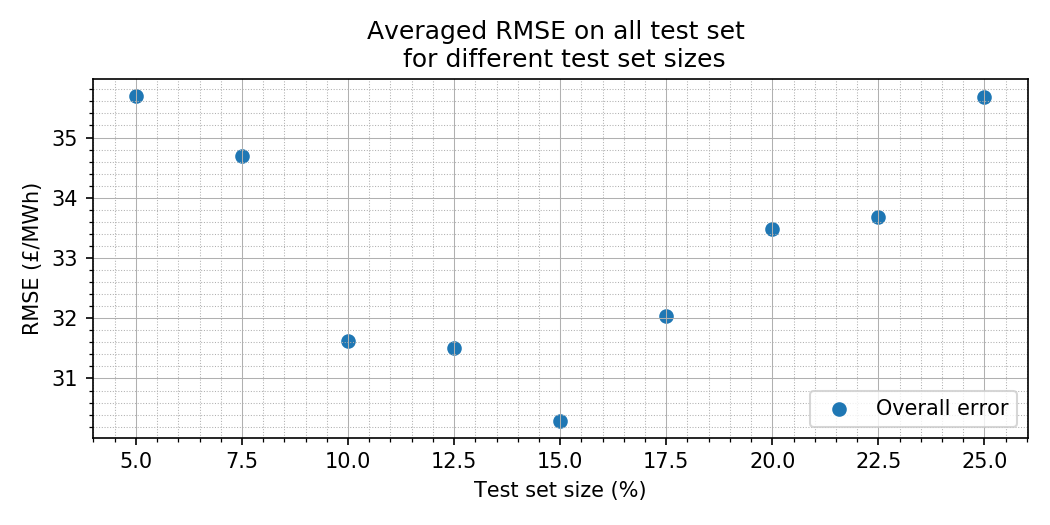

<IPython.core.display.Javascript object>


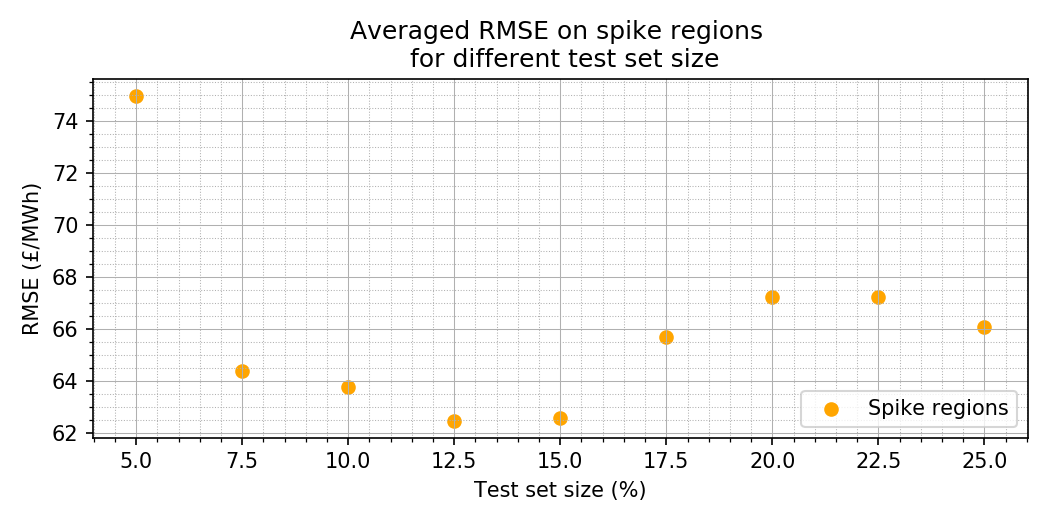

<IPython.core.display.Javascript object>


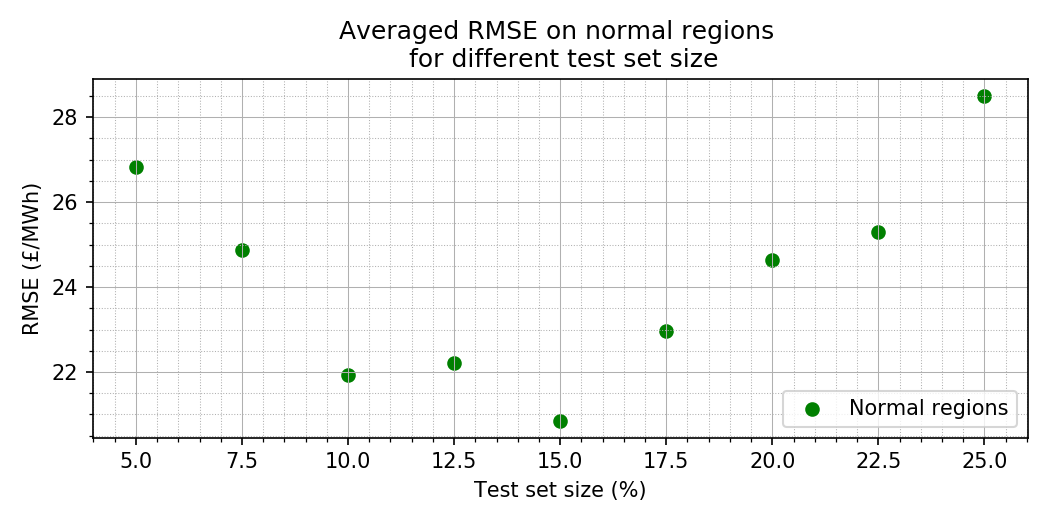

In [30]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on all test set \n for different test set sizes')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = rmse_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_13_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_normal.png')

<IPython.core.display.Javascript object>


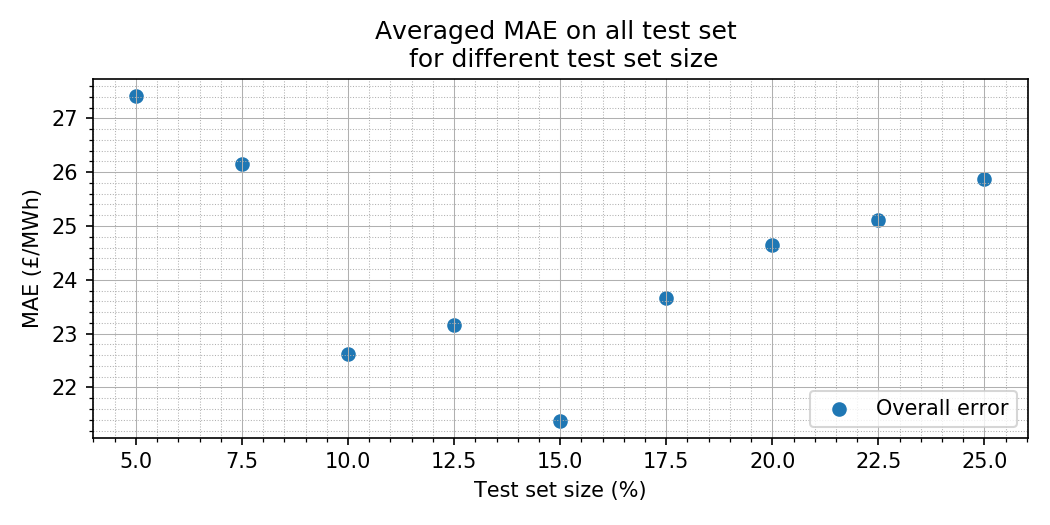

<IPython.core.display.Javascript object>


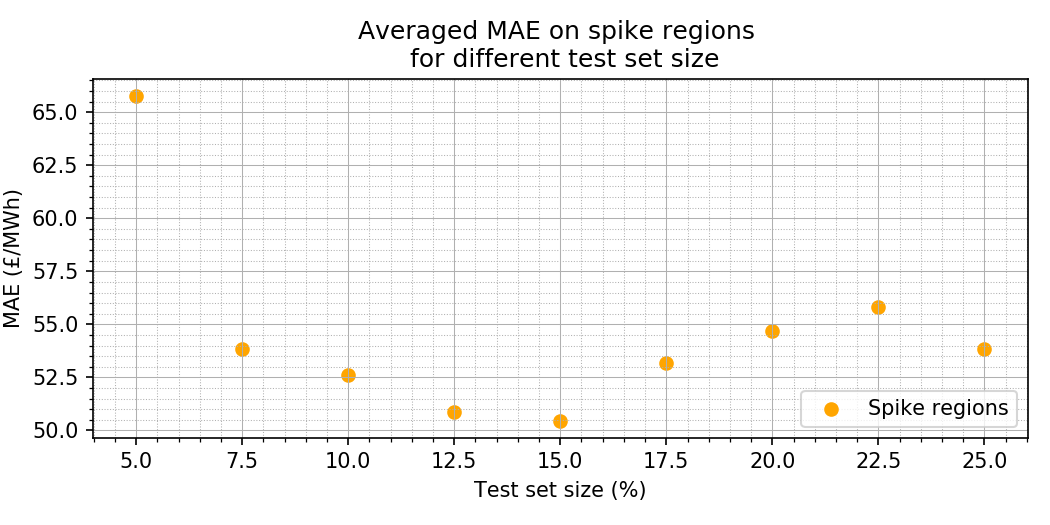

<IPython.core.display.Javascript object>


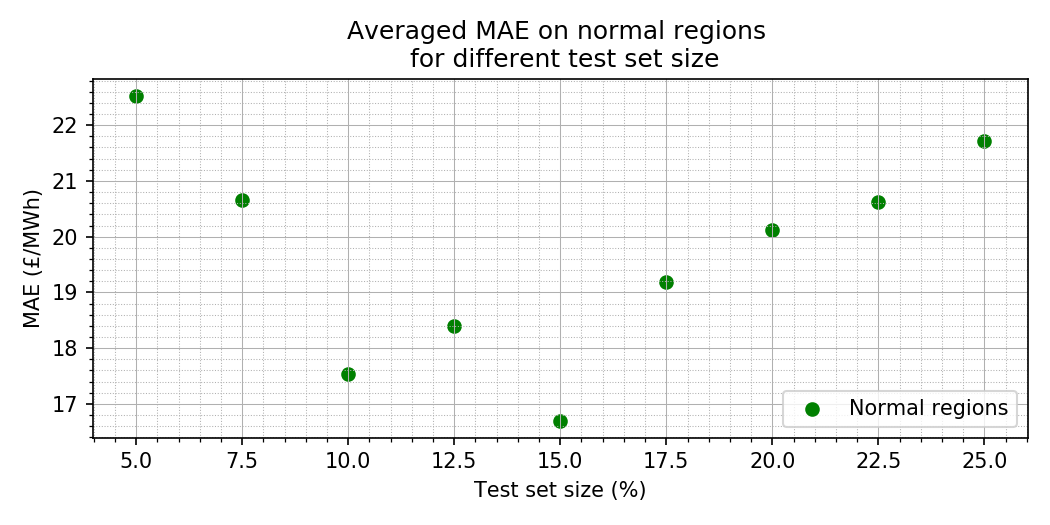

In [31]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on all test set \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =mae_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_normal.png')